# Customer Segmentation

With IGR outlier remover method.

### Import Librarys

In [2]:
# Data Analysis Step
import datetime as dt
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np 
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

# plot parameters
%matplotlib inline
plt.rcParams['font.size'] = 14
plt.rcParams['figure.figsize'] = (9, 5)
plt.rcParams['figure.facecolor'] = '#00000000'

# outliers with mahalanobis
from scipy.spatial import distance


### Import Dataset 

IGR dataset from EAD part

In [4]:
# dataset from the Excel file 

dataset = pd.read_csv('../output/dataset_time_series_igr.csv', parse_dates=['Order Date', 'Ship Date'])
df_igr = dataset.copy()

In [9]:
def summary(df):
    """
    Display a summary of a DataFrame.

    This function displays the first few rows of the DataFrame, basic information about the DataFrame's structure,
    and summary statistics including percentiles.

    Parameters:
    df (DataFrame): The pandas DataFrame to be summarized.

    Returns:
    None
    """

    display(f'Rows: {df.shape[0]}; Columns: {df.shape[1]}')
    display(df.head())
    print('-' * 100)
    display(df.info())
    print('-' * 100)
    display(df.describe([0.01, 0.25, 0.50, 0.75, 0.99]))

In [10]:
summary(df_igr)

'Rows: 45635; Columns: 16'

,Order ID,Order Date,Ship Date,customer ID,Segment,City,State,Region,Country,Market,Product ID,Category,Product Name,Sales,Quantity,Profit
0,ID-2011-24160,2011-12-29,2012-01-01,20170,Consumer,Gold Coast,Queensland,Oceania,Australia,APAC,TEC-PH-10002601,Technology,"Motorola Smart Phone, Cordless",578.502,1,-38.5680
1,ID-2011-24160,2011-12-29,2012-01-01,20170,Consumer,Gold Coast,Queensland,Oceania,Australia,APAC,FUR-BO-10002308,Furniture,"Safco Floating Shelf Set, Metal",353.160,2,39.2400
2,CA-2011-104738,2011-12-30,2012-01-01,20620,Corporate,Laredo,Texas,Central,United States,US,TEC-PH-10002468,Technology,"Plantronics CS 50-USB - headset - Convertible,...",217.584,2,19.0386
3,EG-2011-590,2011-12-28,2012-01-01,5370,Consumer,Sohag,Suhaj,Africa,Egypt,Africa,OFF-SME-10003752,Office Supplies,"Smead File Cart, Single Width",513.720,4,5.0400
4,CA-2011-104738,2011-12-30,2012-01-01,20620,Corporate,Laredo,Texas,Central,United States,US,TEC-PH-10000576,Technology,AT&T 1080 Corded phone,328.776,3,28.7679


----------------------------------------------------------------------------------------------------
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 45635 entries, 0 to 45634
Data columns (total 16 columns):
 #   Column        Non-Null Count  Dtype         
---  ------        --------------  -----         
 0   Order ID      45635 non-null  object        
 1   Order Date    45635 non-null  datetime64[ns]
 2   Ship Date     45635 non-null  datetime64[ns]
 3   customer ID   45635 non-null  int64         
 4   Segment       45635 non-null  object        
 5   City          45635 non-null  object        
 6   State         45635 non-null  object        
 7   Region        45635 non-null  object        
 8   Country       45635 non-null  object        
 9   Market        45635 non-null  object        
 10  Product ID    45635 non-null  object        
 11  Category      45635 non-null  object        
 12  Product Name  45635 non-null  object        
 13  Sales         45635 non-null  float

None

----------------------------------------------------------------------------------------------------


,Order Date,Ship Date,customer ID,Sales,Quantity,Profit
count,45635,45635,45635.00000,45635.000000,45635.000000,45635.000000
mean,2013-05-12 13:16:28.372959232,2013-05-16 12:38:19.393009664,13928.78076,121.659859,3.263789,10.191308
min,2011-01-01 00:00:00,2011-01-03 00:00:00,15.00000,0.444000,1.000000,-1924.542000
1%,2011-02-07 00:00:00,2011-02-10 00:00:00,570.00000,3.488000,1.000000,-225.106860
25%,2012-06-20 00:00:00,2012-06-24 00:00:00,10932.50000,27.180000,2.000000,-0.013200
50%,2013-07-10 00:00:00,2013-07-14 00:00:00,14530.00000,67.080000,3.000000,7.703100
75%,2014-05-22 00:00:00,2014-05-26 00:00:00,18220.00000,168.600000,4.000000,26.661600
99%,2014-12-24 00:00:00,2014-12-29 00:00:00,21775.00000,542.340000,10.000000,179.359200
max,2014-12-31 00:00:00,2015-01-07 00:00:00,21925.00000,581.400000,14.000000,284.220000
std,NaN,NaN,5354.85545,131.533247,2.155229,64.842801


In [6]:
df_igr.dtypes

Order ID                object
Order Date      datetime64[ns]
Ship Date       datetime64[ns]
customer ID              int64
Segment                 object
City                    object
State                   object
Region                  object
Country                 object
Market                  object
Product ID              object
Category                object
Product Name            object
Sales                  float64
Quantity                 int64
Profit                 float64
dtype: object

### Normalize Data Types

## 1 - Calculate Recency, Frequency, and Value:

**RFM (Recency, Frequency, Monetary Value)** analysis is a customer segmentation technique that uses past purchase behaviour to divide customers into groups. RFM helps divide customers into various categories or clusters to identify customers who are more likely to respond to promotions and also for future personalization services.

**RECENCY (R):** Days since last purchase

**FREQUENCY (F):** Total number of purchases

**MONETARY VALUE (M):** Total money this customer spent.

![RFM Analysis](../img/rmf_analysis.png)

### RFM Table

In [11]:
# last order date of the data frame
last_order_date = df_igr['Order Date'].max()

# RFM data frame
df_rfm = df_igr.groupby('customer ID').agg({
    'Order Date': lambda day: (last_order_date - day.max()).days,  #  Recency (number of days since the last purchase)
    'Order ID': lambda num: len(num),  #  Frequency (total number of purchases)
    'Sales': lambda price: price.sum()  # Monetary (total monetary value of purchases)  # total monetary Value of purchases
})

df_rfm.columns = ['Recency','Frequency','Monetary']

df_rfm.head()

,Recency,Frequency,Monetary
customer ID,,,
15,412,10,1250.370
30,468,10,1477.236
45,233,13,1616.334
60,133,10,532.668
75,37,19,2582.940


### RFM Score

The provided code is used to create RFM (Recency, Frequency, Monetary) scores and an overall RFM score for customer segmentation. 

RFM analysis numerically scale each of these three categories for each customer 1 to 5. This is the higher the number, the better the result. The "Best" customer would receive a top score in every category.

***pd.qcut()*** is used to perform quantile-based discretization of the Recency, Frequency, and Monetary scores into five segments each, labeled with values from 1 to 5. These segments will represent the relative ranking of customers for each of the three metrics.

In [12]:
df_rfm["R_Score"]  = pd.qcut(df_rfm['Recency'], 5, [1, 2, 3, 4, 5])
df_rfm["F_Score"]  = pd.qcut(df_rfm['Frequency'],5, [1, 2, 3, 4, 5])
df_rfm["M_Score"]  = pd.qcut(df_rfm['Monetary'], 5, [1, 2, 3, 4, 5])


# sort data frame by Recency
df_rfm = df_rfm.sort_values(by='R_Score', ascending=False)
# concatenate the r, f, m score as string because is a categorical data for better understanding of the customers 
df_rfm["RFM_Score"] = df_rfm["R_Score"].astype(str) + df_rfm["F_Score"].astype(str) + df_rfm["M_Score"].astype(str)

summary(df_rfm)

'Rows: 1590; Columns: 7'

,Recency,Frequency,Monetary,R_Score,F_Score,M_Score,RFM_Score
customer ID,,,,,,,
15,412,10,1250.3700,5,1,2,512
18400,172,52,5706.4061,5,5,4,554
6585,371,2,216.7800,5,1,1,511
6555,175,23,1291.9800,5,3,2,532
6495,398,10,1454.7600,5,1,2,512


----------------------------------------------------------------------------------------------------
<class 'pandas.core.frame.DataFrame'>
Index: 1590 entries, 15 to 21925
Data columns (total 7 columns):
 #   Column     Non-Null Count  Dtype   
---  ------     --------------  -----   
 0   Recency    1590 non-null   int64   
 1   Frequency  1590 non-null   int64   
 2   Monetary   1590 non-null   float64 
 3   R_Score    1590 non-null   category
 4   F_Score    1590 non-null   category
 5   M_Score    1590 non-null   category
 6   RFM_Score  1590 non-null   object  
dtypes: category(3), float64(1), int64(2), object(1)
memory usage: 67.4+ KB


None

----------------------------------------------------------------------------------------------------


,Recency,Frequency,Monetary
count,1590.000000,1590.000000,1590.000000
mean,87.593082,28.701258,3491.790977
std,129.897253,19.059298,2690.471999
min,0.000000,1.000000,7.173000
1%,0.000000,3.000000,145.435680
25%,14.000000,11.000000,1060.040250
50%,37.000000,25.000000,2738.931950
75%,103.000000,45.000000,5779.169600
99%,637.440000,69.000000,9573.933765
max,1206.000000,88.000000,12105.200500


### 2 - Segment Customers

1. **Champions:** Bought recently, buy often and spend the most
2. **Loyal customers:** Buy on a regular basis. Responsive to promotions.
3. **Potential loyalist:** Recent customers with average frequency.
4. **Recent customers:** Bought most recently, but not often.
5. **Promising:** Recent shoppers, but haven’t spent much.
6. **Needs attention:** Above average recency, frequency and monetary values. May not have bought very recently though.
7. **About to sleep:** Below average recency and frequency. Will lose them if not reactivated.
8. **At risk:** Some time since they’ve purchased. Need to bring them back!
9. **Can’t lose them:** Used to purchase frequently but haven’t returned for a long time.
10. **Hibernating:** Last purchase was long back and low number of orders. May be lost.

![RFM Segementation](../img/rm_r_x_fm.jpg)

In [13]:
# calc FM_Score
df_rfm['FM_Score'] = round((df_rfm['F_Score'].astype(int) + df_rfm['M_Score'].astype(int)) / 2)

df_rfm['FM_Score'].unique()

array([2., 4., 1., 3., 5.])

In [14]:
# create the R(FM_Score)
df_rfm['R(FM)_Score'] = df_rfm['R_Score'].astype(str) + df_rfm['FM_Score'].astype(str)

# remove decimal
df_rfm['R(FM)_Score'] = df_rfm['R(FM)_Score'].str.replace('.0', '', regex=False) 

df_rfm.head()


,Recency,Frequency,Monetary,R_Score,F_Score,M_Score,RFM_Score,FM_Score,R(FM)_Score
customer ID,,,,,,,,,
15,412,10,1250.3700,5,1,2,512,2.0,52
18400,172,52,5706.4061,5,5,4,554,4.0,54
6585,371,2,216.7800,5,1,1,511,1.0,51
6555,175,23,1291.9800,5,3,2,532,2.0,52
6495,398,10,1454.7600,5,1,2,512,2.0,52


In [15]:
# df_rfm['R(FM)_Score'].unique()

# convert to string
df_rfm['R(FM)_Score'] = df_rfm['R(FM)_Score'].astype(str)
df_rfm['R(FM)_Score'].dtype

dtype('O')

In [16]:
# segmentation map
# regex R[1-5], FM[1-5]
seg_map = {
    r'11': 'Lost',
    r'12': 'Hibernating',
    r'13': 'About to Sleep',
    r'14': 'Promising',
    r'15': 'New Customers',
    r'21': 'At Risk',
    r'22': 'Need Attention',
    r'23': 'Potential Loyalist',
    r'24': "Can't Lose Them",
    r'25': 'Loyal Customers',
    r'31': 'Needs Attention',
    r'32': 'About to Sleep',
    r'33': 'At Risk',
    r'34': 'Promising',
    r'35': 'New Customers',
    r'41': 'At Risk',
    r'42': 'About to Sleep',
    r'43': 'Promising',
    r'44': "Can't Lose Them",
    r'45': 'Loyal Customers',
    r'51': 'Champions',
    r'52': 'Champions',
    r'53': 'Champions',
    r'54': 'Champions',
    r'55': 'Champions'
}

In [17]:
def apply_segmentation(df, column_name, seg_map):
    """
    Apply segmentation to a DataFrame based on a given column and segmentation map.

    Parameters:
        df (DataFrame): The DataFrame to segment.
        column_name (str): The name of the column to be segmented.
        seg_map (dict): A dictionary containing regular expressions as keys and segment names as values.

    Returns:
        DataFrame: The original DataFrame with an additional 'Segment' column.
    """
    # Check if the specified column exists in the DataFrame
    if column_name not in df.columns:
        raise ValueError(f"Column '{column_name}' does not exist in the DataFrame.")

    # Apply the mapping function to create a new 'Segment' column
    df['RFM_Segment'] = df[column_name].astype(str).replace(seg_map, regex=True)
    
    return df

In [18]:
df_rfm.head()

,Recency,Frequency,Monetary,R_Score,F_Score,M_Score,RFM_Score,FM_Score,R(FM)_Score
customer ID,,,,,,,,,
15,412,10,1250.3700,5,1,2,512,2.0,52
18400,172,52,5706.4061,5,5,4,554,4.0,54
6585,371,2,216.7800,5,1,1,511,1.0,51
6555,175,23,1291.9800,5,3,2,532,2.0,52
6495,398,10,1454.7600,5,1,2,512,2.0,52


In [19]:
# apply function to create a new 'RFM_Class' column
df_rfm = apply_segmentation(df_rfm, 'R(FM)_Score', seg_map)

df_rfm.head()

,Recency,Frequency,Monetary,R_Score,F_Score,M_Score,RFM_Score,FM_Score,R(FM)_Score,RFM_Segment
customer ID,,,,,,,,,,
15,412,10,1250.3700,5,1,2,512,2.0,52,Champions
18400,172,52,5706.4061,5,5,4,554,4.0,54,Champions
6585,371,2,216.7800,5,1,1,511,1.0,51,Champions
6555,175,23,1291.9800,5,3,2,532,2.0,52,Champions
6495,398,10,1454.7600,5,1,2,512,2.0,52,Champions


In [20]:
df_rfm['RFM_Segment'].unique()

array(['Champions', 'About to Sleep', "Can't Lose Them", 'At Risk',
       'Promising', 'Loyal Customers', 'Needs Attention', 'New Customers',
       'Potential Loyalist', 'Need Attention', 'Lost', 'Hibernating'],
      dtype=object)

### R(FM) Segmentation readily answers

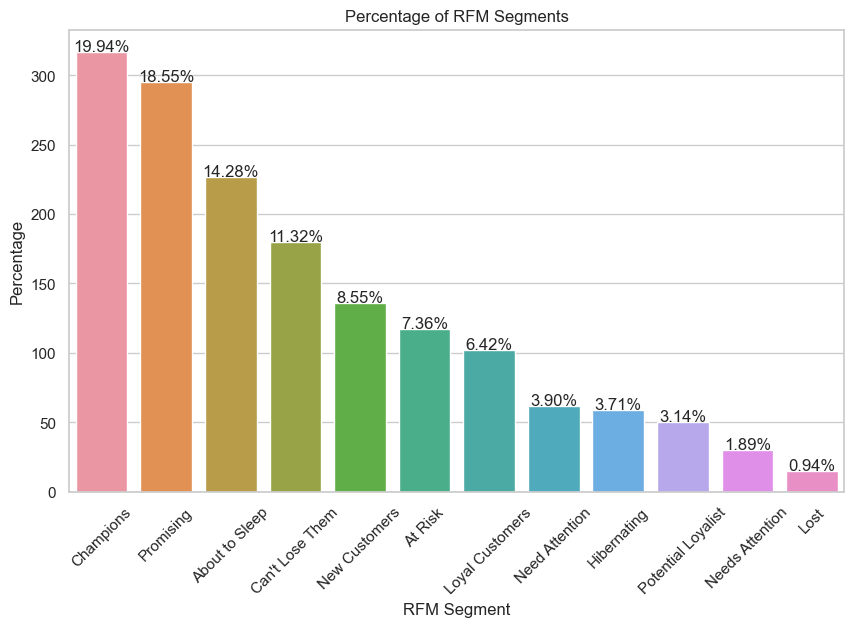

In [21]:
# create a countplot
plt.figure(figsize=(10, 6))
sns.set(style="whitegrid")
ax = sns.countplot(data=df_rfm, x='RFM_Segment', order=df_rfm['RFM_Segment'].value_counts().index)

# display percentage on top of each bar
total = len(df_rfm)
for p in ax.patches:
    height = p.get_height()
    ax.text(p.get_x() + p.get_width() / 2, height + 0.5, f"{height/total*100:.2f}%", ha="center")

# pie char
plt.title("Percentage of RFM Segments")
plt.xlabel("RFM Segment")
plt.ylabel("Percentage")
plt.xticks(rotation=45)
plt.show()

**Who are my best customers?**(Champions)

In [22]:
df_rfm[df_rfm['RFM_Segment'] == 'Champions'].sort_values('M_Score', ascending=False).head()


,Recency,Frequency,Monetary,R_Score,F_Score,M_Score,RFM_Score,FM_Score,R(FM)_Score,RFM_Segment
customer ID,,,,,,,,,,
16915,149,46,7400.9430,5,4,5,545,4.0,54,Champions
18400,172,52,5706.4061,5,5,4,554,4.0,54,Champions
20500,175,43,5048.0880,5,4,4,544,4.0,54,Champions
14380,145,32,5071.2777,5,3,4,534,4.0,54,Champions
19180,160,43,5843.7813,5,4,4,544,4.0,54,Champions


**Which customers are at the verge of churning?**

Churn rate is a measure of the number of customers or employees who leave a company during a given period. It can also refer to the amount of revenue lost as a result of the departures (Biscobing 2023).

Customers who's recency value is low

In [23]:
df_rfm['R_Score'] = df_rfm['R_Score'].astype(int) # convert r_score to int

verge_churn = df_rfm['R_Score'] <= 2
total_customers = verge_churn.sum()
print(f"total customers in verge of churning: {total_customers}")

total customers in verge of churning: 661


**Who are the lost customers?**

Customers who's recency, frequency as well as monetary values are low 

In [24]:
lost = df_rfm['RFM_Segment']=='Lost'
total_lost_customers = verge_churn.sum()

print(f"total lost customers: {total_lost_customers}")
df_rfm[lost].sort_values('Recency',ascending=False).head()

total lost customers: 661


,Recency,Frequency,Monetary,R_Score,F_Score,M_Score,RFM_Score,FM_Score,R(FM)_Score,RFM_Segment
customer ID,,,,,,,,,,
11295,12,7,730.908,1,1,1,111,1.0,11,Lost
10935,11,7,487.746,1,1,1,111,1.0,11,Lost
11835,8,6,461.490,1,1,1,111,1.0,11,Lost
6765,8,5,729.090,1,1,1,111,1.0,11,Lost
2535,7,6,147.120,1,1,1,111,1.0,11,Lost


**Who are loyal customers?**

Customers with high frequency value

In [25]:
high_f = df_rfm['F_Score'] >= 4 
total_loyal_customers = high_f.sum()

print(f"total of loyest customers: {total_loyal_customers}")
df_rfm[high_f].sort_values('Recency', ascending=False).head()

total of loyest customers: 627


,Recency,Frequency,Monetary,R_Score,F_Score,M_Score,RFM_Score,FM_Score,R(FM)_Score,RFM_Segment
customer ID,,,,,,,,,,
9285,254,38,4501.7580,5,4,4,544,4.0,54,Champions
20500,175,43,5048.0880,5,4,4,544,4.0,54,Champions
18400,172,52,5706.4061,5,5,4,554,4.0,54,Champions
19180,160,43,5843.7813,5,4,4,544,4.0,54,Champions
19645,150,39,3436.8463,5,4,3,543,4.0,54,Champions


####  All Overall view of RFM Analysis

In [26]:
df_rfm[["RFM_Segment","Recency", "Frequency", "Monetary"]].groupby("RFM_Segment").agg(["mean", "count","sum"])

Recency               Frequency               \
                          mean count    sum       mean count    sum   
RFM_Segment                                                           
About to Sleep       55.947137   227  12700  16.110132   227   3657   
At Risk              62.786325   117   7346  13.897436   117   1626   
Can't Lose Them      41.927778   180   7547  42.961111   180   7733   
Champions           293.741325   317  93116  11.000000   317   3487   
Hibernating           5.508475    59    325  13.186441    59    778   
Lost                  5.600000    15     84   6.666667    15    100   
Loyal Customers      35.813725   102   3653  57.519608   102   5867   
Need Attention       19.241935    62   1193  13.048387    62    809   
Needs Attention      40.466667    30   1214   6.966667    30    209   
New Customers        17.073529   136   2322  58.000000   136   7888   
Potential Loyalist   20.140000    50   1007  27.760000    50   1388   
Promising            29.715254   295   8766  40.993220   295  12093   

                       Monetary                      
                           mean count           sum  
RFM_Segment                                          
About to Sleep      1676.953625   227  3.806685e+05  
At Risk             1346.521212   117  1.575430e+05  
Can't Lose Them     5405.154811   180  9.729279e+05  
Champions           1112.850698   317  3.527737e+05  
Hibernating         1311.489203    59  7.737786e+04  
Lost                 532.353600    15  7.985304e+03  
Loyal Customers     7698.135336   102  7.852098e+05  
Need Attention      1228.157419    62  7.614576e+04  
Needs Attention      452.687300    30  1.358062e+04  
New Customers       7820.916243   136  1.063645e+06  
Potential Loyalist  3122.507861    50  1.561254e+05  
Promising           5111.746810   295  1.507965e+06

## Bibliography

- J. Biscobing, , "What is churn rate?". [Online]. Available: https://www.techtarget.com/searchcustomerexperience/definition/churn-rate. [Accessed: Octuber 23, 2023].
- A. Bajaj, "RFM Analysis For Successful Customer Segmentation using Python," Medium, May 2019. [Online]. Available: https://aainabajaj39.medium.com/rfm-analysis-for-successful-customer-segmentation-using-python-6291decceb4b. [Accessed: Octuber 30, 2023].
- ComunidadeDS, "Como fazer uma segmentação de clientes com RFM?," 2021, [Online]. Available: https://www.youtube.com/watch?v=CArRKwrLaeM. [Accessed: Octuber 25, 2023].
- U. Savcı, "Customer Segmentation using RFM Analysis in Python," 2022, [Online]. Available: https://medium.com/@ugursavci/customer-segmentation-using-rfm-analysis-in-python-218a3255f714. [Accessed: Octuber 24, 2023].
- U. Savcı, "Step by Step Customer Segmentation using K-Means in Python," 2022, [Online]. Available: https://medium.com/@ugursavci/step-by-step-customer-segmentation-using-k-means-and-pca-in-python-5733822295b6. [Accessed: Octuber 24, 2023].



 









 